# State Abstraction Visualization

In [1]:
import numpy as np
import pandas as pd
import json
import dataclasses
from dataclasses import dataclass, fields, _MISSING_TYPE
from heapq import heappush, heappop, heappushpop
from collections import OrderedDict
import math
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from entropy_calculation import uncertainty
from state_utils import get_spacy_info, get_llm_info, align_llm_spacy_output, get_model_state, StateOverview
from sentence_transformers import SentenceTransformer
from numpy.linalg import norm
from scipy.spatial.distance import cityblock, minkowski, jaccard


In [2]:
# load embedding model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# sentences to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Embeddings are constructed by the system for the input sentences']

# embedding vector
doc_1, doc_2 = model.encode(sentences)

# compute cosine similarity
cosine = np.dot(doc_1, doc_2)/(norm(doc_1)*norm(doc_2))
# compute Euclidean distance
euclidean = math.dist(doc_1, doc_2)
# compute dot product
dot_product = np.dot(doc_1, doc_2)
#calculate Manhattan distance between vectors
manhattan = cityblock(doc_1, doc_2)
# Minkowski distance
minkowski_distance = minkowski(doc_1, doc_2)
# Jaccard similarity
jaccard_sim = jaccard(doc_1, doc_2)
print(f"Cosine similarity: {cosine} \n" + 
      f"Euclidean distance: {euclidean} \n" + 
      f"Dot product: {dot_product} \n" + 
      f"Manhattan distance: {manhattan} \n" + 
      f"Minkowski distance: {minkowski_distance} \n"+ 
      f"Jaccard similarity: {jaccard_sim} \n")


Cosine similarity: 0.8059834241867065 
Euclidean distance: 0.6229230424800573 
Dot product: 0.805983304977417 
Manhattan distance: 13.636821746826172 
Minkowski distance: 0.6229230761528015 
Jaccard similarity: 1.0 



In [3]:
# load embedding model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# sentences to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Embeddings are constructed by the system for the input sentences']

# embedding vector
doc_1, doc_2 = model.encode(sentences)

# compute cosine similarity
cosine = np.dot(doc_1, doc_2)/(norm(doc_1)*norm(doc_2))
# compute Euclidean distance
euclidean = math.dist(doc_1, doc_2)
# compute dot product
dot_product = np.dot(doc_1, doc_2)
#calculate Manhattan distance between vectors
manhattan = cityblock(doc_1, doc_2)
# Minkowski distance
minkowski_distance = minkowski(doc_1, doc_2)
# Jaccard similarity
jaccard_sim = jaccard(doc_1, doc_2)
print(f"Cosine similarity: {cosine} \n" + 
      f"Euclidean distance: {euclidean} \n" + 
      f"Dot product: {dot_product} \n" + 
      f"Manhattan distance: {manhattan} \n" + 
      f"Minkowski distance: {minkowski_distance} \n"+ 
      f"Jaccard similarity: {jaccard_sim} \n")


Cosine similarity: 0.8059834241867065 
Euclidean distance: 0.6229230424800573 
Dot product: 0.805983304977417 
Manhattan distance: 13.636821746826172 
Minkowski distance: 0.6229230761528015 
Jaccard similarity: 1.0 



### Load Sample Dataset

In [4]:
# load sample response from datasets
load_path = "/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/response_data/"
dataset_name = "reponse_eli5_category_train_100.json"

df = pd.read_json(load_path+dataset_name)

print(f"dataset name: {dataset_name} \n" + 
      f"num of questions: {len(df)} \n" +
      f"dataset keys: {list(df.columns)} \n\n")

# take first reponse for later processing 
sample_response = df.iloc[3]

# extract response info 
num_token_response = sample_response["completion_tokens"]
top_k_prob = np.array(sample_response["top_k_prob"])
top_k_token = np.array(sample_response["top_k_token"])
top_logprobs = sample_response["top_logprobs"]
question = sample_response["question"]
text = sample_response["text"]
llm_token = sample_response["token"]

# display question, response from llm,  true answer
print(f"Question: {sample_response['question']} \n\n" + 
      f"Response: {repr(''.join((sample_response['text'])))} \n\n" + 
      f"Answer: {repr(''.join((sample_response['answer'])))} \n")

dataset name: reponse_eli5_category_train_100.json 
num of questions: 100 
dataset keys: ['question', 'answer', 'prompt', 'text', 'token', 'top_k_token', 'top_k_prob', 'top_logprobs', 'prompt_tokens', 'completion_tokens', 'response'] 


Question: Why is it that we calm down when we take a deep breath, hold it for a few seconds and exhale? 

Response: '\n\nTaking a deep breath helps to activate the parasympathetic nervous system, which is responsible for calming the body down. When we take a deep breath, we are sending a signal to the brain to relax and slow down. Holding the breath for a few seconds helps to increase the oxygen levels in the body, which can help to reduce stress and anxiety. Exhaling helps to release the tension in the body and can help to reduce stress levels.' 

Answer: 'Anxiety/stress are the result of your sympathetic nervous system being activated (fight or flight response). When we are threatened we experience a variety of physical effects, e.g. increased heart r

### State Construction

In [5]:
nlp = spacy.load("en_core_web_lg")
doc = nlp(text)
nlp_result = get_spacy_info(doc)
llm_result = get_llm_info(text, llm_token, top_k_prob, top_k_token)
align_result = align_llm_spacy_output(nlp_result, llm_result, verbose=False)
states = get_model_state(align_result)
final_states = StateOverview(states, 4, ("NOUN", "VERB"), 0.3, "sentence", nlp)

### LLM output visualization

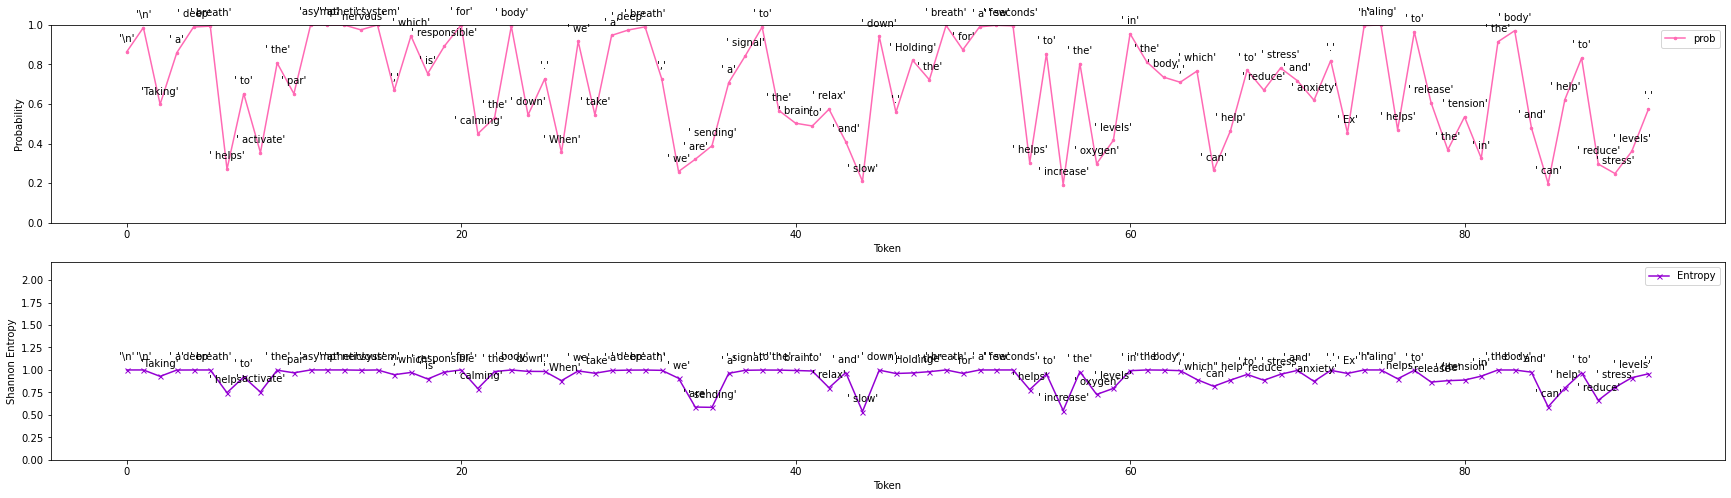

In [6]:
# plotting
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']
token_count = np.arange(num_token_response)
answer_uncert = np.zeros([len(top_k_prob), 6])
for i in range(0, len(top_k_prob)):
    answer_uncert[i,:] = uncertainty(top_k_prob[i,:])

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(token_count, top_k_prob[:,0], marker=".", markersize=5, c=plot_colors[0], label="prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'Token')
axs[0].legend()
axs[0].set_ylim([0, 1])


axs[1].plot(token_count, answer_uncert[:,0], marker="x", markersize=5, c=plot_colors[1], label="Entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("Token")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([top_k_prob[:,0], answer_uncert[:,0]]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(token_count, value):

        label = repr(top_k_token[x,0])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### State Probability, Entropy

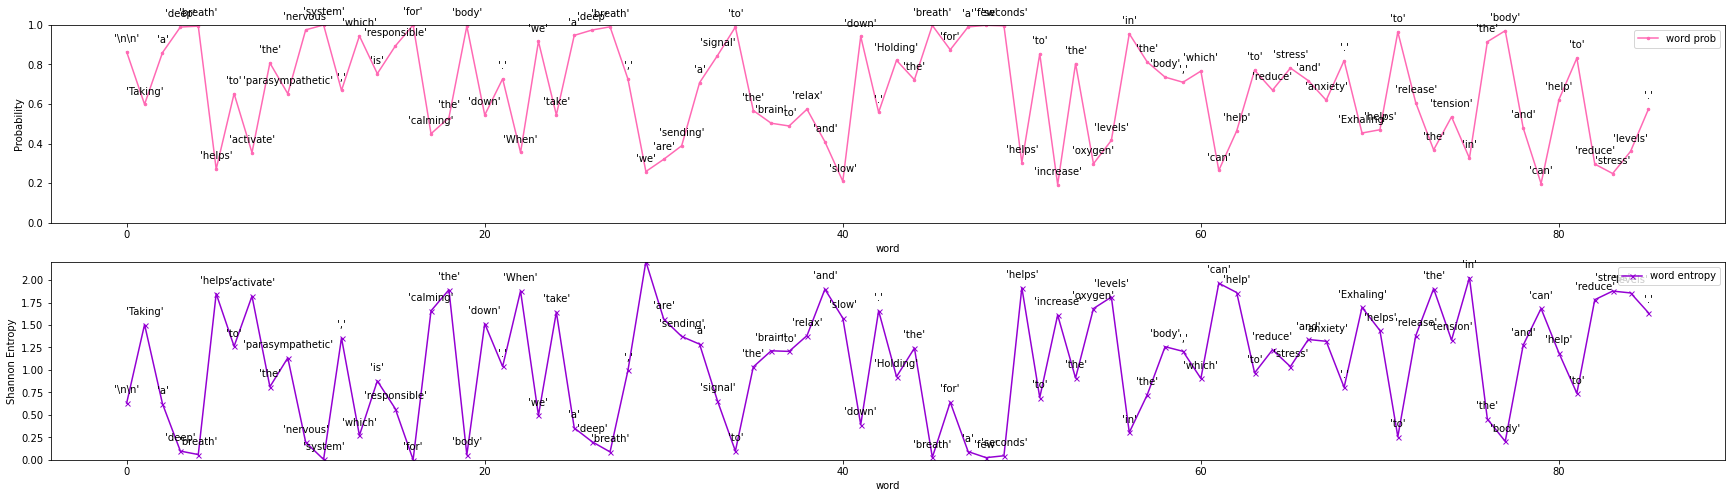

In [7]:
state_text = [state.token for state in final_states.states]
state_probability = [state.probability for state in final_states.states]
state_entropy = [state.entropy for state in final_states.states]
state_count = np.arange(len(state_text))

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(state_count, state_probability, marker=".", markersize=5, c=plot_colors[0], label="word prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'word')
axs[0].legend()
axs[0].set_ylim([0, 1])


axs[1].plot(state_count, state_entropy, marker="x", markersize=5, c=plot_colors[1], label="word entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("word")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([state_probability, state_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### State Weighted prob, entropy

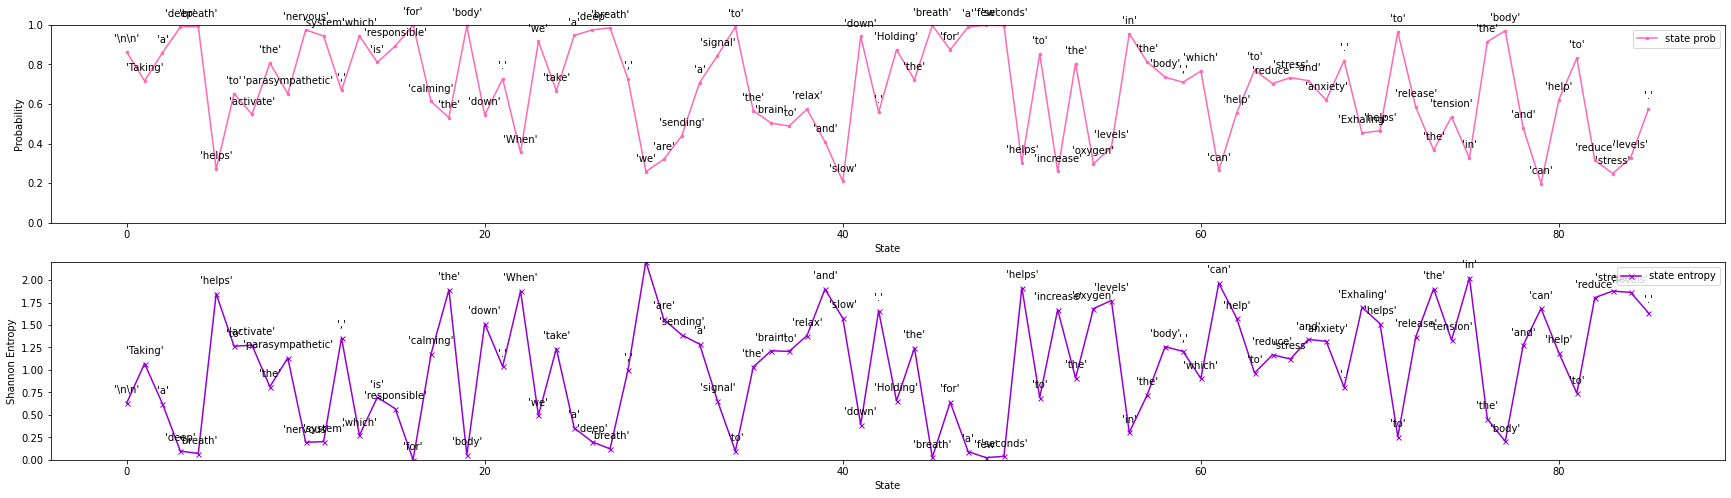

In [8]:
state_weighted_probability = [state.statistics.weighted_prob for state in final_states.states]
state_weighted_entropy = [state.statistics.weighted_entropy for state in final_states.states]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(state_count, state_weighted_probability, marker=".", markersize=5, c=plot_colors[0], label="state prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(state_count, state_weighted_entropy, marker="x", markersize=5, c=plot_colors[1], label="state entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([state_weighted_probability, state_weighted_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### State with selected tag: NOUN and VERB

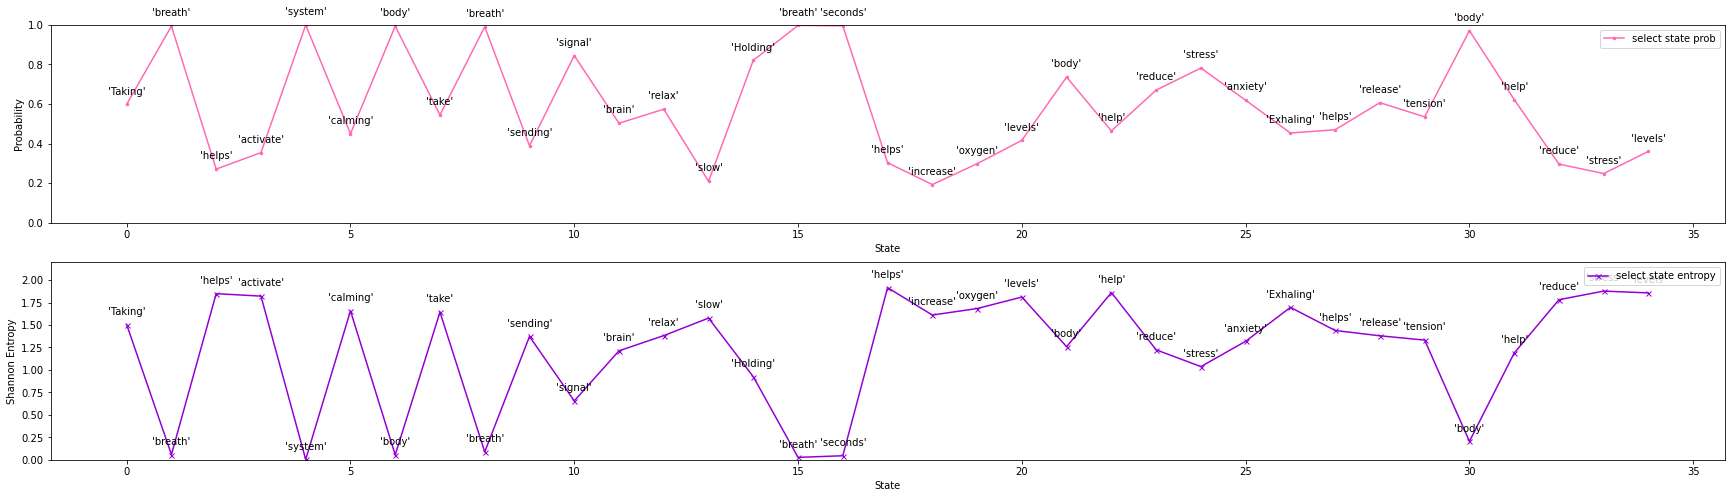

In [9]:
target_tag = set(["NOUN", "VERB"])
select_state = []

for state in final_states.states:
    if state.prop_tag.pos_tag in target_tag:
        select_state.append(state)

select_state_text = [state.token for state in select_state]
select_state_probability = [state.probability for state in select_state]
select_state_entropy = [state.entropy for state in select_state]
select_state_count = np.arange(len(select_state_text))

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_state_probability, marker=".", markersize=5, c=plot_colors[0], label="select state prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_state_entropy, marker="x", markersize=5, c=plot_colors[1], label="select state entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_state_probability, select_state_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Weighted State with selected tag: NOUN and VERB

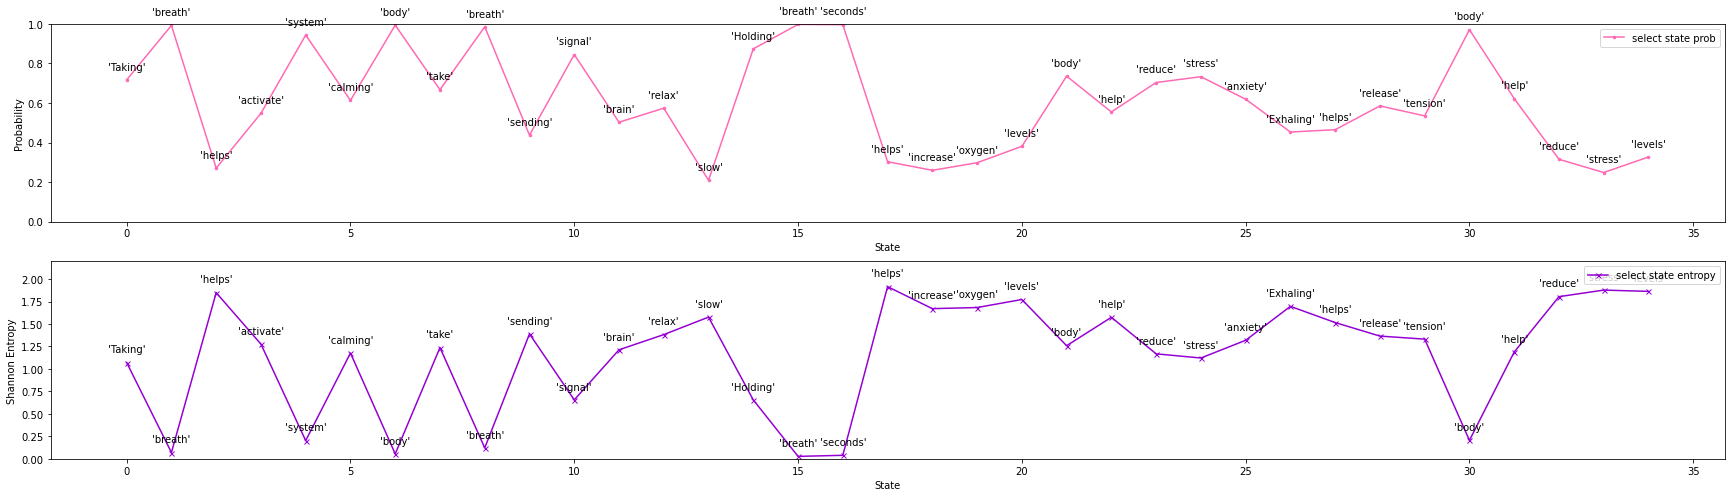

In [10]:
select_state_weight_probability = [state.statistics.weighted_prob for state in select_state]
select_state_weight_entropy = [state.statistics.weighted_entropy for state in select_state]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_state_weight_probability, marker=".", markersize=5, c=plot_colors[0], label="select state prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_state_weight_entropy, marker="x", markersize=5, c=plot_colors[1], label="select state entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_state_weight_probability, select_state_weight_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Sentence-level Moving Mean Prob, Entropy

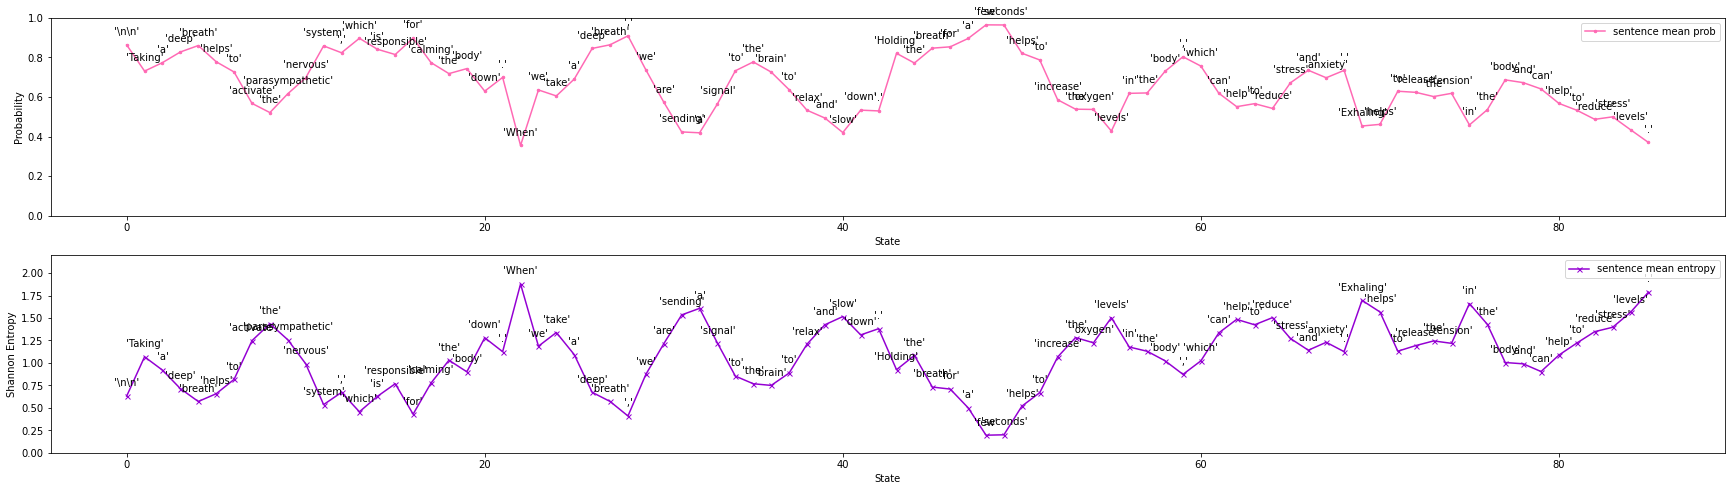

In [11]:
sentence_mean_prob = [state.statistics.moving_mean["sentence_prob"] for state in final_states.states]
sentence_mean_entropy = [state.statistics.moving_mean["sentence_entropy"] for state in final_states.states]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(state_count, sentence_mean_prob, marker=".", markersize=5, c=plot_colors[0], label="sentence mean prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(state_count, sentence_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="sentence mean entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([sentence_mean_prob, sentence_mean_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Sentence-level Selcted State Moving Mean Prob, Entropy

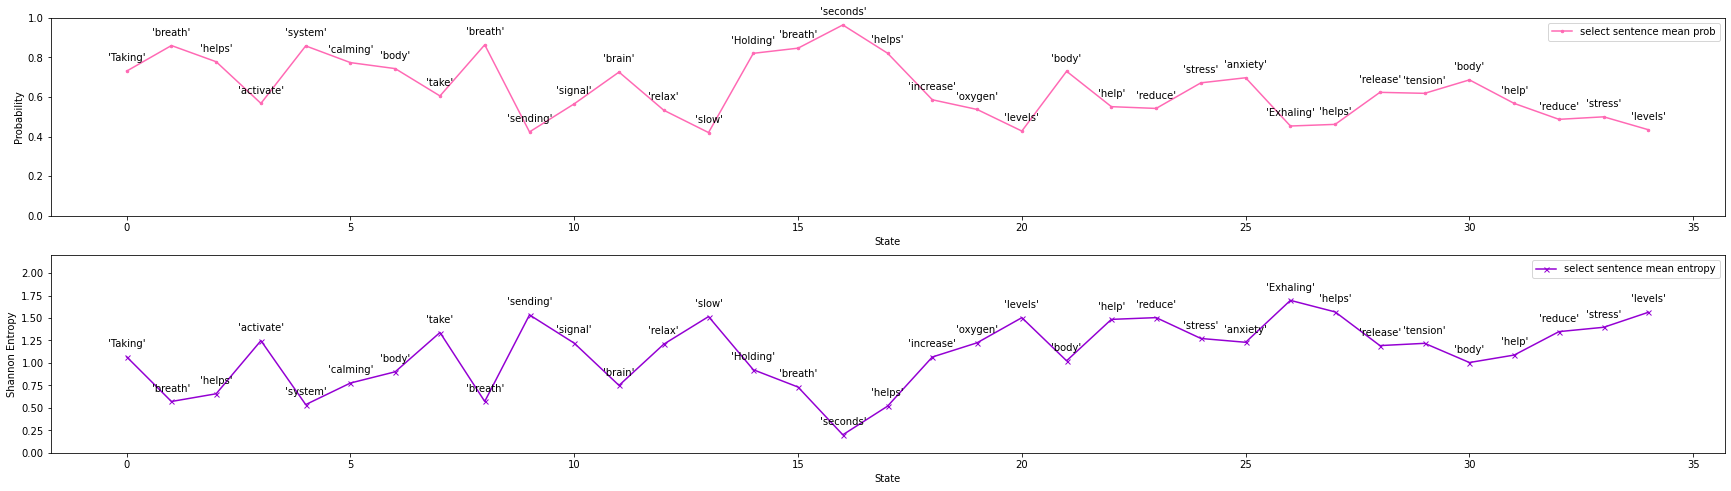

In [12]:
select_sentence_mean_prob = [state.statistics.moving_mean["sentence_prob"] for state in select_state]
select_sentence_mean_entropy = [state.statistics.moving_mean["sentence_entropy"] for state in select_state]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_sentence_mean_prob, marker=".", markersize=5, c=plot_colors[0], label="select sentence mean prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_sentence_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="select sentence mean entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_sentence_mean_prob, select_sentence_mean_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Sentence-level Selcted Weighted State Moving Mean Prob, Entropy

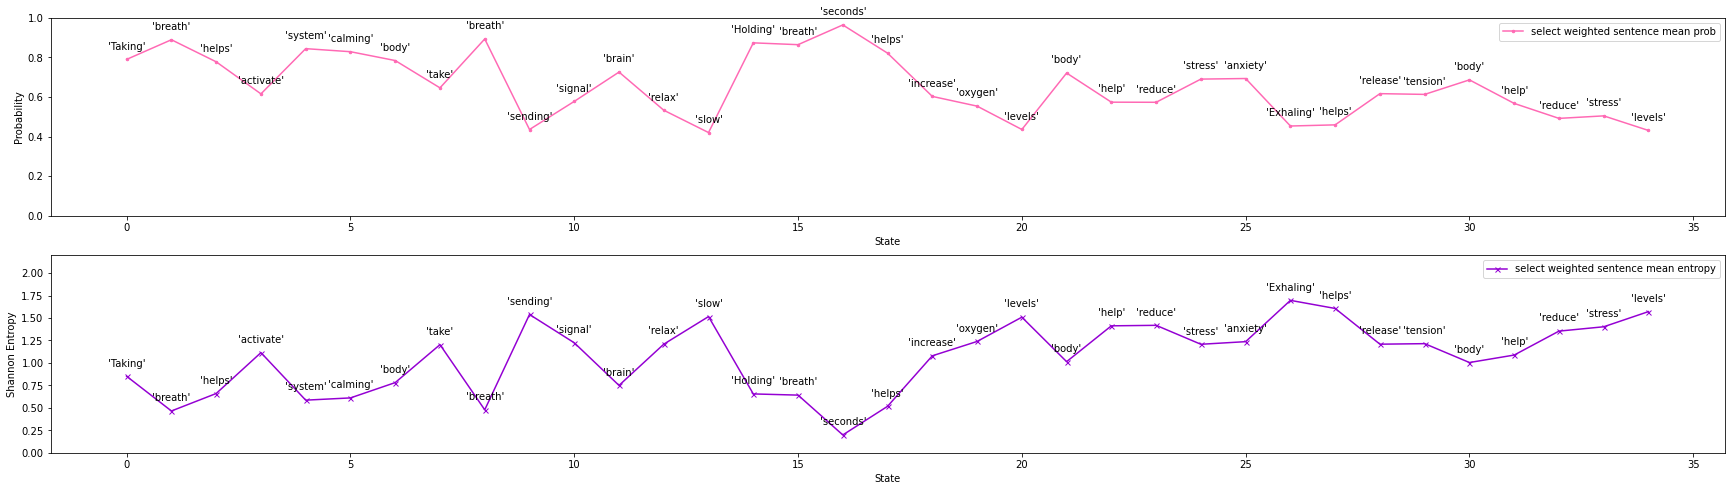

In [13]:
select_weight_sentence_mean_prob = [state.statistics.weighted_moving_mean["sentence_prob"] for state in select_state]
select_weight_sentence_mean_entropy = [state.statistics.weighted_moving_mean["sentence_entropy"] for state in select_state]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_weight_sentence_mean_prob, marker=".", markersize=5, c=plot_colors[0], label="select weighted sentence mean prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_weight_sentence_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="select weighted sentence mean entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_weight_sentence_mean_prob, select_weight_sentence_mean_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Sentence-level Moving RMSE Prob, Entropy

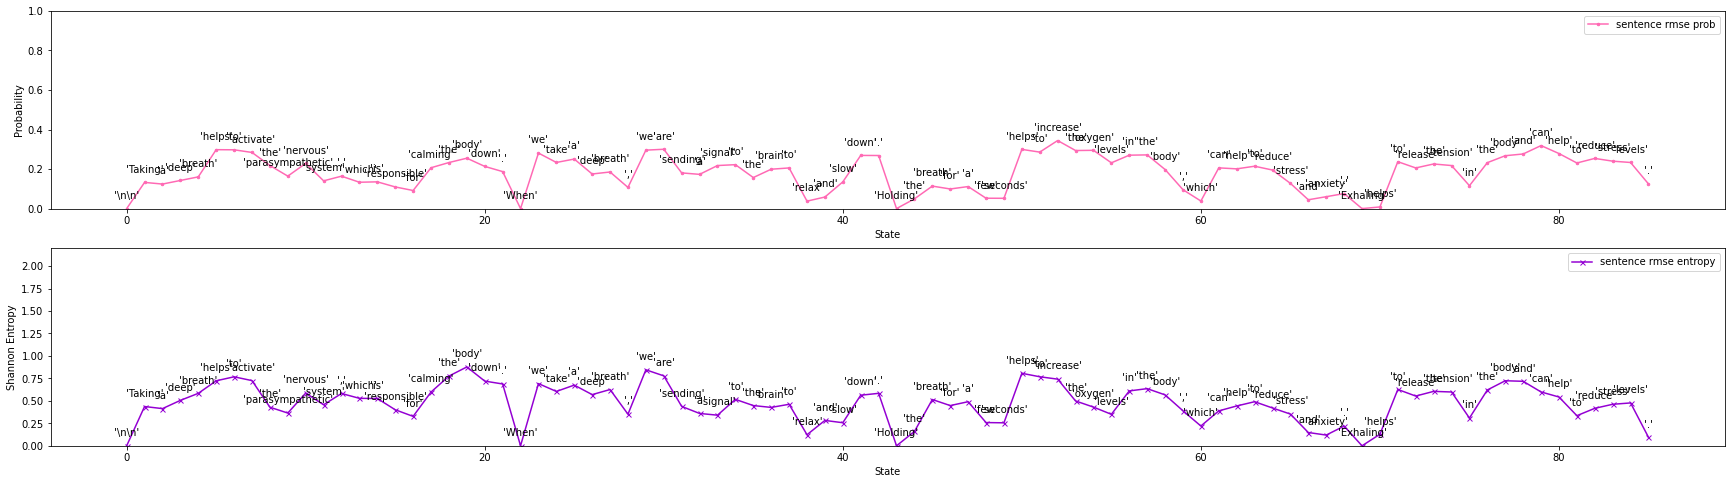

In [14]:
sentence_rmse_prob = [state.statistics.moving_rmse["sentence_prob"] for state in final_states.states]
sentence_rmse_entropy = [state.statistics.moving_rmse["sentence_entropy"] for state in final_states.states]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(state_count, sentence_rmse_prob, marker=".", markersize=5, c=plot_colors[0], label="sentence rmse prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(state_count, sentence_rmse_entropy, marker="x", markersize=5, c=plot_colors[1], label="sentence rmse entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([sentence_rmse_prob, sentence_rmse_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Sentence-level Selected State Moving RMSE Prob, Entropy

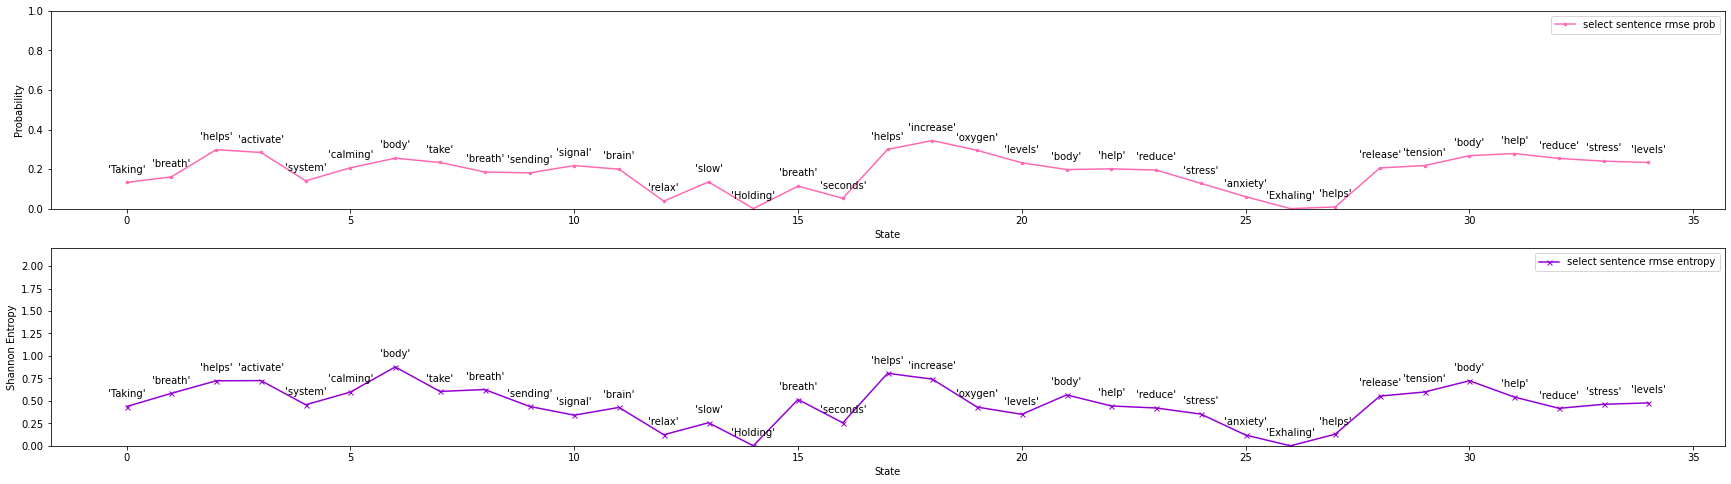

In [15]:
select_sentence_rmse_prob = [state.statistics.moving_rmse["sentence_prob"] for state in select_state]
select_sentence_rmse_entropy = [state.statistics.moving_rmse["sentence_entropy"] for state in select_state]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_sentence_rmse_prob, marker=".", markersize=5, c=plot_colors[0], label="select sentence rmse prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_sentence_rmse_entropy, marker="x", markersize=5, c=plot_colors[1], label="select sentence rmse entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_sentence_rmse_prob, select_sentence_rmse_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Sentence-level Selected Weighted State Moving RMSE Prob, Entropy

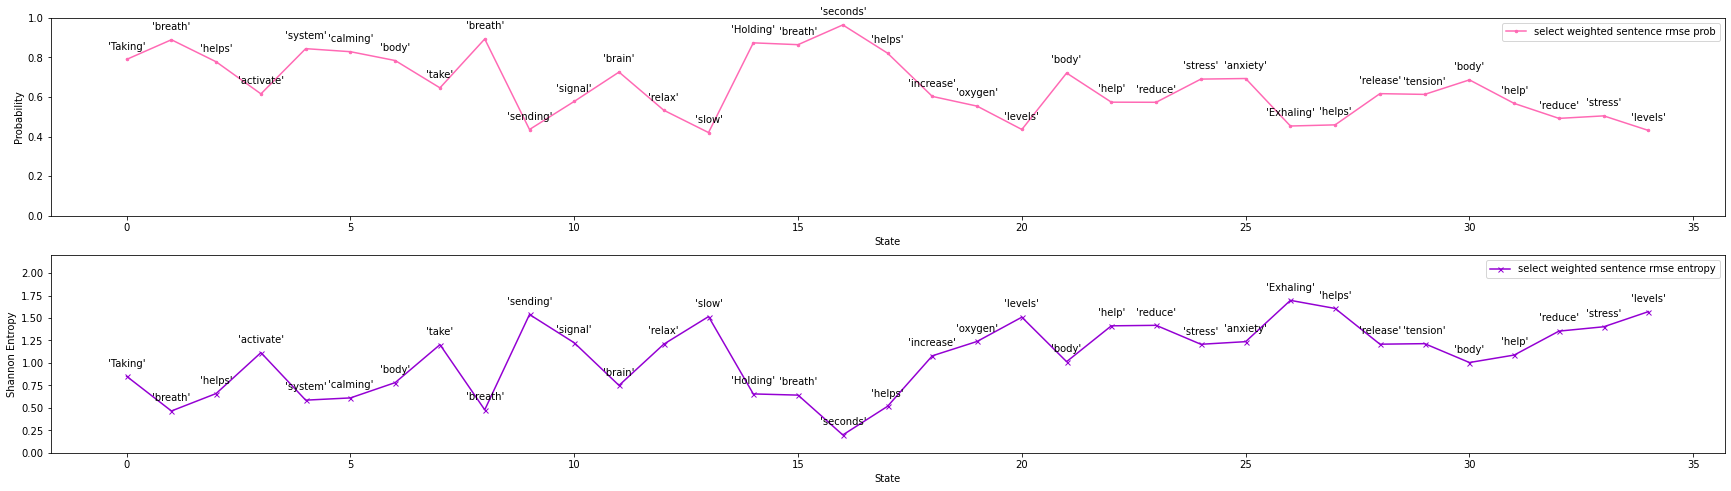

In [16]:
select_weight_sentence_rmse_prob = [state.statistics.weighted_moving_mean["sentence_prob"] for state in select_state]
select_weight_sentence_rmse_entropy = [state.statistics.weighted_moving_mean["sentence_entropy"] for state in select_state]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_weight_sentence_rmse_prob, marker=".", markersize=5, c=plot_colors[0], label="select weighted sentence rmse prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_weight_sentence_rmse_entropy, marker="x", markersize=5, c=plot_colors[1], label="select weighted sentence rmse entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_weight_sentence_rmse_prob, select_weight_sentence_rmse_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### State Moving Median, Prob and Entropy

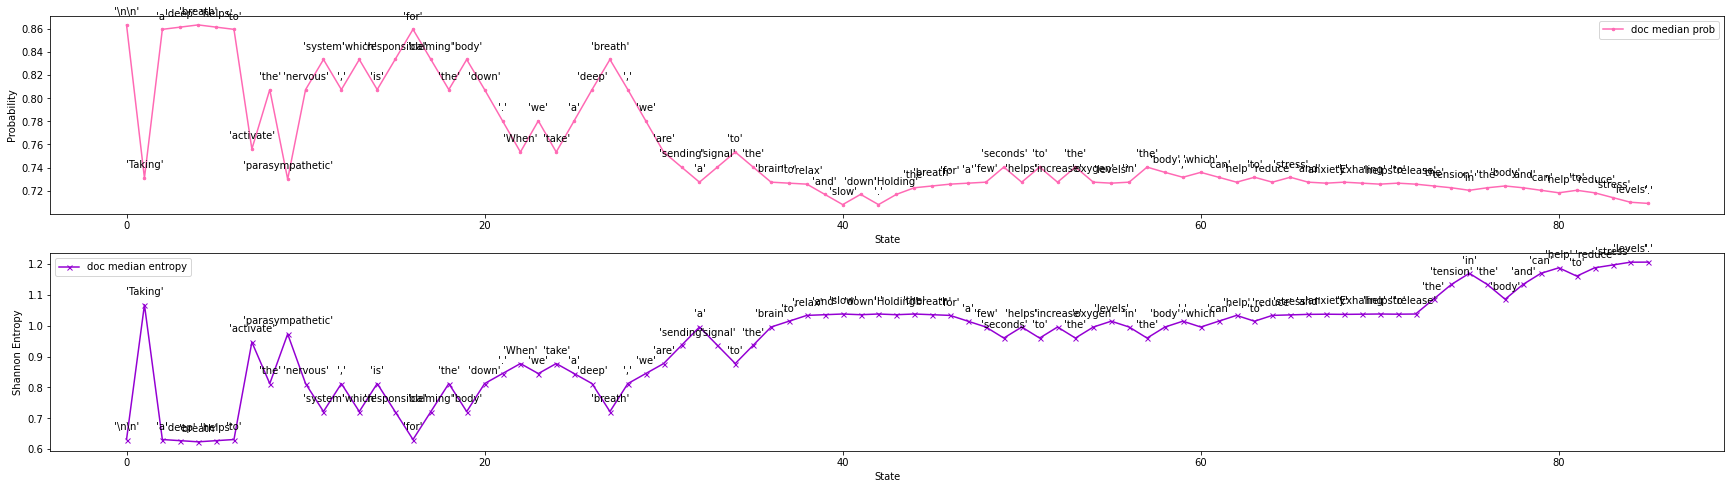

In [17]:
doc_median_prob = [state.statistics.moving_doc_median["probability"] for state in final_states.states]
doc_median_entropy = [state.statistics.moving_doc_median["entropy"] for state in final_states.states]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(state_count, doc_median_prob, marker=".", markersize=5, c=plot_colors[0], label="doc median prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
# axs[0].set_ylim([0, 1])

axs[1].plot(state_count, doc_median_entropy, marker="x", markersize=5, c=plot_colors[1], label="doc median entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
# axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([doc_median_prob, doc_median_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Selected State Moving Median, Prob and Entropy

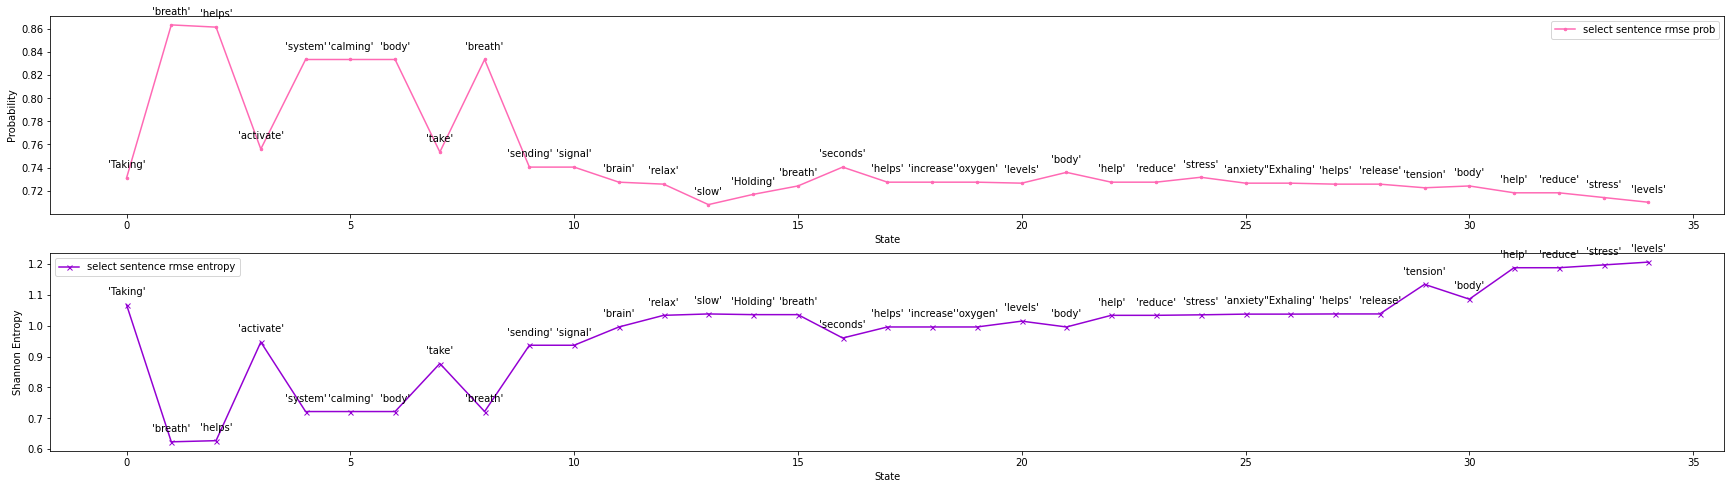

In [18]:
select_doc_median_prob = [state.statistics.moving_doc_median["probability"] for state in select_state]
select_doc_median_entropy = [state.statistics.moving_doc_median["entropy"] for state in select_state]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_doc_median_prob, marker=".", markersize=5, c=plot_colors[0], label="select sentence rmse prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
# axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_doc_median_entropy, marker="x", markersize=5, c=plot_colors[1], label="select sentence rmse entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
# axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_doc_median_prob, select_doc_median_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### Selected Weighted State Moving Median, Prob and Entropy

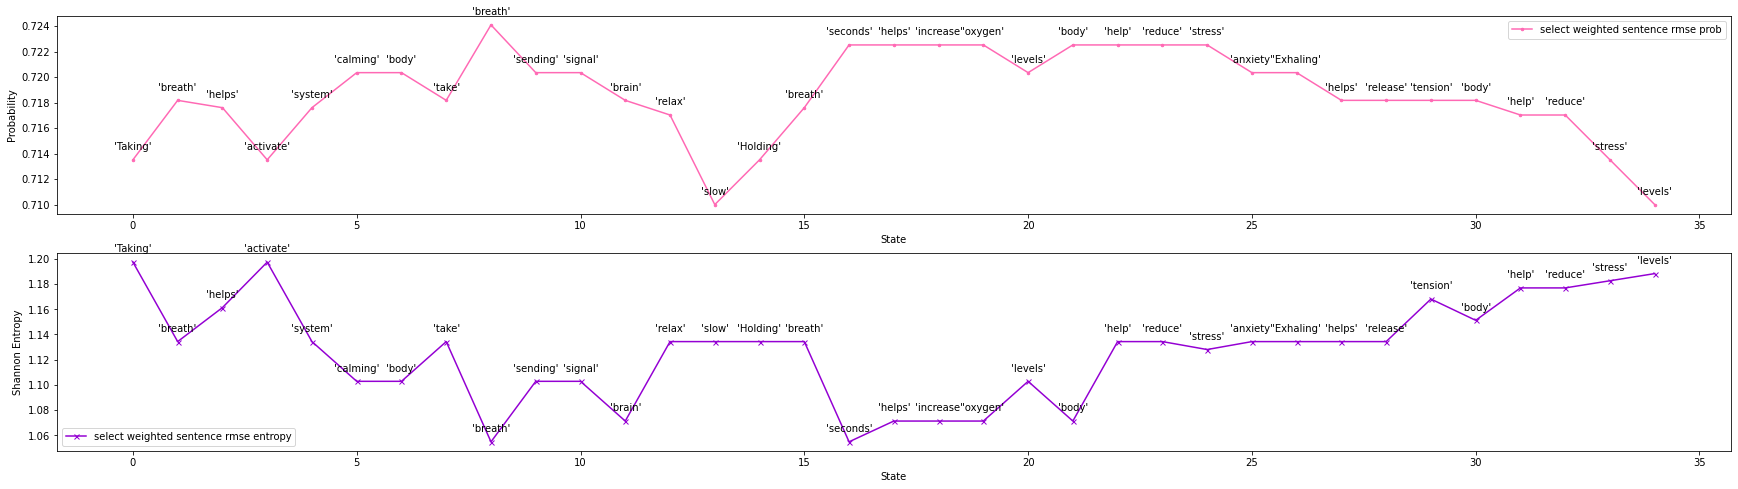

In [19]:
select_weight_doc_median_prob = [state.statistics.weighted_moving_doc_median["probability"] for state in select_state]
select_weight_doc_median_entropy = [state.statistics.weighted_moving_doc_median["entropy"] for state in select_state]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(select_state_count, select_weight_doc_median_prob, marker=".", markersize=5, c=plot_colors[0], label="select weighted sentence rmse prob")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
# axs[0].set_ylim([0, 1])

axs[1].plot(select_state_count, select_weight_doc_median_entropy, marker="x", markersize=5, c=plot_colors[1], label="select weighted sentence rmse entropy")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
# axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_weight_doc_median_prob, select_weight_doc_median_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()